# Predicting Play Duration Based On Age and Experience Level
## Introduction

A UBC research group has set up a Minecraft server with the intention of collecting data about how people play video games. They collect data by recording user gameplay as they navigate throughout the minecraft server. In order to maximize their data collection, they need to know which type of players to recruit, as well as when and how to recruit them. Thus, our project aims to find how different characteristics of players impact how long people play Minecraft for and how often. 

Data provided to us includes two data sets: players.csv and sessions.csv. Sessions.csv provides specific time stamps of when players logged onto minecraft server and when they logged off as well as providing an anonymous email that correlates to players specific in the players dataset. Nevertheless, only players.csv was used to answer the question since it provided sufficient information. 

Players.csv contains a list of player characteristics such as name, gender, age, experience, how long they have played minecraft for on the UBC server, and more. The dataset provides a great amount of detail for each player. The experience column includes 5 categories: Amateur, Beginner, Pro, Regular, and Veteran. Meanwhile, the gender column has a wide variety of genders including male, female, non-binary, agender, two-spirited, and other/prefer-not-to-say. Although these columns were provided to us as character data types (chr), for our analysis we will consider them to be factor data types (fct).


The tables below contains information about the columns in each data set.

Players data:

| Variable Name | Type | Meaning |
|---------------|------|---------|
| experience    | chr  | amount of experience a player has in Minecraft |
| subscribe     | lgl | whether the player is subscribed to emails |
| hashedEmail   | chr | players email in hashed (coded) form, unique identifier |
| played_hours    | dbl | number of hours played on the server |
| name          | chr | player's pseudonym on PLAIcraft |
| gender        | chr | player's chosen gender |
| age | dbl | player's chosen age in years |
| individualId | lgl | not accessible: if individual has an id  |
| organizationName | lgl | not accessible: if signup is from an organization |

Sessions data:

| Variable Name | Type | Meaning |
|---------------|------|---------|
| hashedEmail | chr | players email in hashed (coded) form, unique identifier |
| start_time | chr | date and time when the player logged onto the server |
| end_time | chr | date and time when the player logged off the server |
| original_start_time | dbl | a time in UNIX timestamp format, logging the scheduled <br> start time as number of seconds since January 1 1970 at UTC |
| original_end_time | dbl | a time in UNIX timestamp format, logging the scheduled <br> end time as number of seconds since January 1 1970 at UTC |

The question we are trying to answer is: **"Can we predict the amount of time a player will play given their age and gender?"** To answer the question, we will be using K-nn regression to predict the amount of time a user will play given their age and experience level. As mentioned above, we will only be using the players data set as it contains all the information we need to conduct our analysis. The response variable is `played_hours` and the predictor variables are `age` and `experience`. This will allow us to predict what demographic a person with a large play time would have, hence who would be able to contribute the most data from playing the longest.

It is important to note that there are some issues with the players data set. The data collection method involved collecting player input through a survey, however self-reported data may not always be accurate. For example, many people lie about their age online and there is no way to verify that a player’s chosen age is their real age. Innacurate data may affect the results of the data analysis and should be taken into consideration.

## Methods and Results

For this project, we will begin by using wrangling techniques to clean the data, then creating exploratory visualizations, and finally creating a KNN regression model to make predictions.

First, we will load the libraries needed to perform our analysis.

In [61]:
# load libraries
library(tidyverse)
library(tidymodels)
library(tibble)
library(tidyclust)
set.seed(1)

Then, we will load the data using read_csv.

In [62]:
# read data
players_data <- read_csv("https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz")
head(players_data)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


To perform K-nn regression, all variables must be numerical. This means we need to convert `experience` from characters into numbers. We will put the `experience` variable on a scale of 1-5 so each value has equal weight. We also need to filter our data set so that it only includes the columns necessary for analysis: `age`, `experience`, `and played_hours`

In [63]:
# convert categorical experience data into numerical data
players  <- players_data |> 
    mutate(experience = case_when(
        experience == "Amateur" ~ 1,
        experience == "Beginner" ~ 2,
        experience == "Pro" ~ 3,
        experience == "Regular" ~ 4,
        experience == "Veteran" ~ 5,)) |>
    select(experience, played_hours, age)  # select only the columns needed for analysis
head(players)

experience,played_hours,age
<dbl>,<dbl>,<dbl>
3,30.3,9
5,3.8,17
5,0.0,17
1,0.7,21
4,0.1,21
1,0.0,17


Since we are performing K-nn regression, we need to split our data into training and testing sets, where we will first create the model using training data, then test its accuracy with testing data. It is important to set the seed before splitting the data as it ensures the data is split in the same way every time, making it reproducible. 

In [64]:
set.seed(1)

# split data into training and testing
players_split <- initial_split(players, prop = 0.75, strata = played_hours)
players_train <- training(players_split)
players_test <- testing(players_split)

Now that we have split the data, we can perform exploratory analysis on the data set through visualizations. First we will create a bar chart displaying the count of each `experience` value in the data set. To do this, we need to convert `experience` into a factor type.

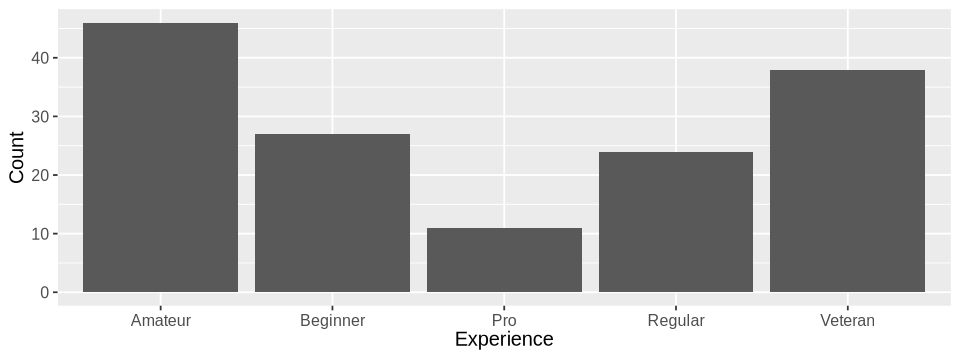

In [65]:
# convert the experience column into a factor to plot as a bar graph
players_mutate <- players_train |>
    mutate(fct_experience = factor(experience, 
                                   levels = 1:5,
                                   labels = c("Amateur", "Beginner", "Pro", "Regular", "Veteran")))
# plot experience counts
players_ex <- players_mutate |>
  ggplot(aes(x = fct_experience)) +
      geom_bar() +
      labs(x = "Experience",
           y = "Count") +
      theme(text = element_text(size = 12))

players_ex

This shows that the 'amateur' experience level has the most counts of players and 'pro' has the least.

We can also plot `experience` against `played_hours`.

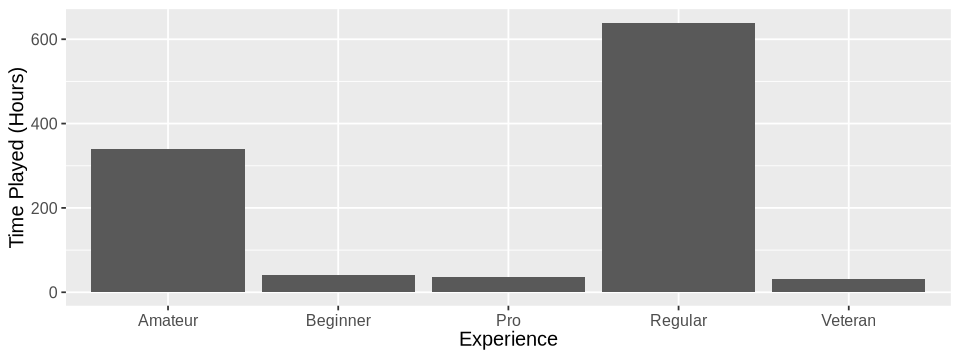

In [66]:
ex_vs_hrs <- players_mutate |>
  ggplot(aes(x = fct_experience, y = played_hours)) +
      geom_bar(stat = "identity") +
      labs(x = "Experience",
           y = "Time Played (Hours)") +
      theme(text = element_text(size = 12))

ex_vs_hrs

This shows that `regular` and `amateur` players have contributed the most time in the current data set.

We can also view the distribution of ages in the data set.

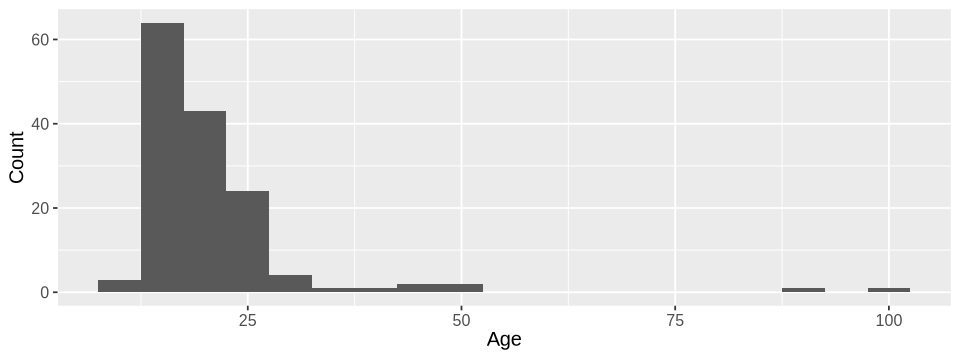

In [67]:
age_dist <- players_train |>
    ggplot(aes(x = age)) +
        geom_histogram(binwidth = 5) +
        labs(x="Age", y="Count") +
        theme(text = element_text(size = 12))
age_dist

This shows that most of the data comes from players under the age of 25.

Finally, we can plot `age` against `played_hours`.

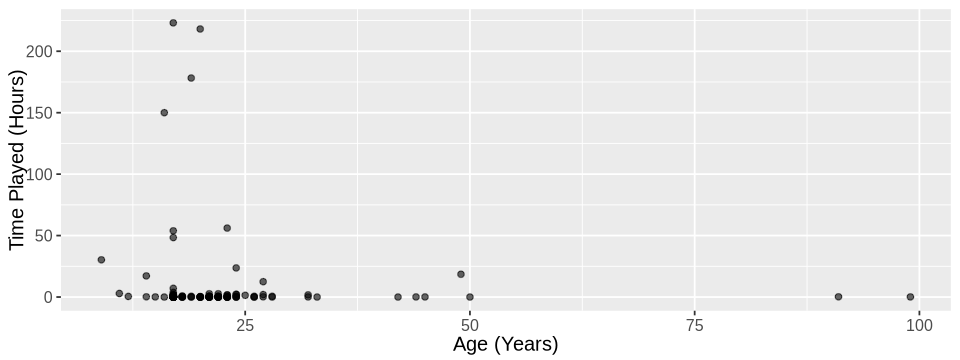

In [68]:
age_vs_hrs <- players_train |>
  ggplot(aes(x = age, y = played_hours)) +
      geom_point(alpha = 0.6) +
      labs(x = "Age (Years)",
           y = "Time Played (Hours)") +
      theme(text = element_text(size = 12))
age_vs_hrs

From the graph above, we can see that the overall distribution of age is skewed, with the majority of players at an age of ~12-25. This also seems to be the region where played hours reaches the highest points. However, in order to analyse a tangible trend, we must perform KNN regression.

Now that we have an understanding of the data set, we can begin building our K-nn regression model. To pick the optimal K value, we will use cross validation to test a sequence of k values and choose the one that produces the lowest rmse.

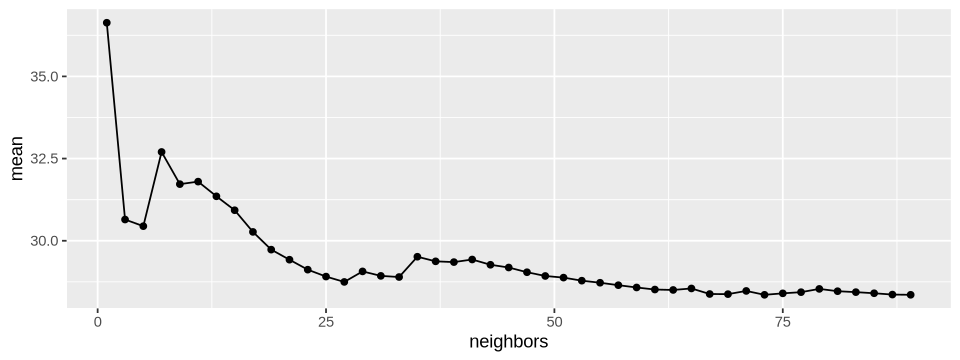

In [69]:
set.seed(1)

# 1. create the recipe
players_recipe <- recipe(played_hours ~ age + experience, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# 2. create the model specification with neighbors set to tune()
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

# 3. create a 5-fold cross validation object
players_vfold <- vfold_cv(players_train, v = 5, strata = played_hours)

# 4. create a workflow
players_wkflw <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec)

# 5. create grid of possible k values
gridvals <- tibble(neighbors = seq(from = 1, to = 90, by = 2))

# 6. tune the model with the possible k values and collect metrics
players_results <- players_wkflw |>
    tune_grid(resamples = players_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

# 7. visualize metrics
plot_results <- players_results |>
    ggplot(aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line()
plot_results

In [70]:
# 8. find optimal k value
min_kval <- players_results |>
    filter(mean == min(mean))
min_kval

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
73,rmse,standard,28.35536,5,8.384103,Preprocessor1_Model37


At k = 73, we find the lowest RMSE. Now we can use k = 73 to create our final model and make predictions. Once again, we will recreate the model with 73 neighbours, and fit it into the workflow using the training data. We will then use the training data to predict the testing data.

In [71]:
kmin <- min_kval |> pull(neighbors)
# recreate model with kmin
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
    set_engine("kknn") |>
    set_mode("regression")

# fit the model with the training data
players_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_spec) |>
    fit(data = players_train)

# predict on the testing data
players_predictions <- players_fit |>
    predict(players_test) |>
    bind_cols(players_test) |>
    arrange(played_hours)

head(players_predictions)

.pred,experience,played_hours,age
<dbl>,<dbl>,<dbl>,<dbl>
5.230137,1,0,17
9.416438,4,0,19
5.210959,1,0,21
10.250685,3,0,17
5.210959,1,0,22
9.739726,5,0,23


Based on the first few predictions, the model does not appear to be very accurate. To visualize the predictions against the actual played hours we would need a 3D graph since we are using 2 predictor variables. Instead, we could plot the predicted values against one variable at a time, such as age. 

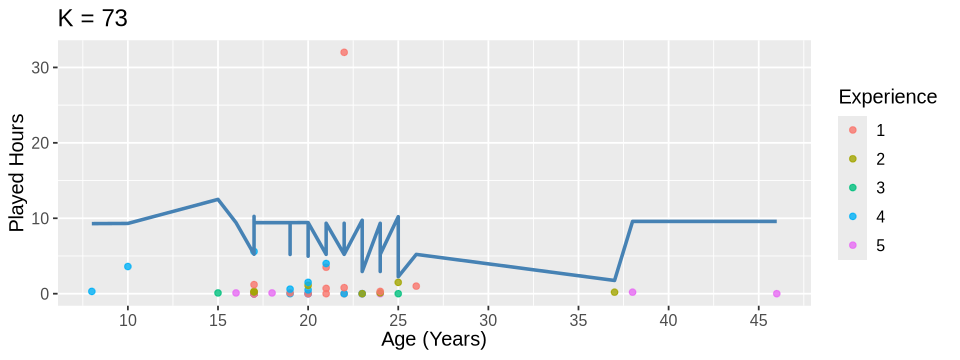

In [72]:
players_predictions_visualized <- ggplot(players_predictions, aes(x = age, y = played_hours, color = as.factor(experience))) +
    geom_point(alpha = 0.8) +
    geom_line(data = players_predictions,
            mapping = aes(x = age, y = .pred),
            color = "steelblue",
            linewidth = 1) +
    ggtitle(paste0("K = ", kmin)) +
    theme(text = element_text(size = 12)) +
    scale_x_continuous(breaks=seq(0,50,by=5)) +
    labs(x = "Age (Years)",
         y = "Played Hours",
         color = "Experience")
players_predictions_visualized

Let's refine the visualization to analyse further in-depth. It is difficult to read right now because of the stretched scale due to the outlier (who played 32 hours), so we will remove the outlier to get a better picture of the overall trend. Furthermore, while we currently have a picture of all ages, researchers will likely want to know which age within the majority age range (15-25) has the most average played time. For the next visualization, it will focus on this range only (although again, it is still important to note data of ages outside this range!).

Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 7 rows containing missing values or values outside the scale range
(`geom_line()`).”


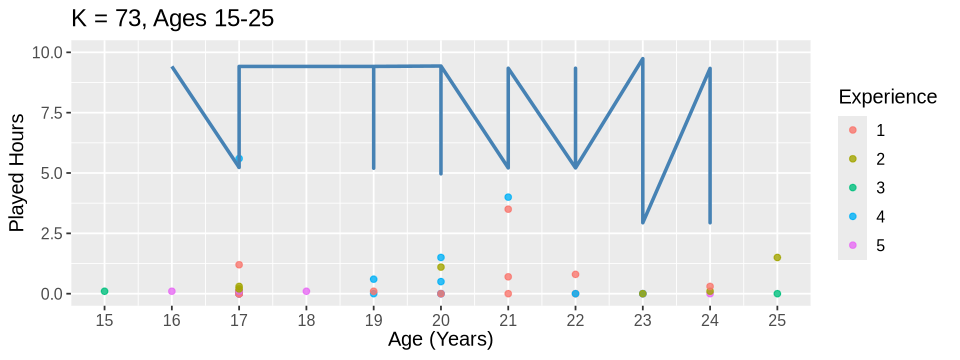

In [73]:
options(repr.plot.width = 8, repr.plot.height = 3)

# create a visualization for this age range without outliers
players_predictions_visualized_new <- ggplot(players_predictions, aes(x = age, y = played_hours, color = as.factor(experience))) +
    geom_point(alpha = 0.8) +
    geom_line(data = players_predictions,
        mapping = aes(x = age, y = .pred),
        color = "steelblue",
        linewidth = 1) +
    theme(text = element_text(size = 12)) +
    labs(x = "Age (Years)",
         y = "Played Hours",
         color = "Experience",
         title = "K = 73, Ages 15-25") +
    scale_x_continuous(breaks=seq(15,25,by=1), 
                       lim = c(15, 25)) +
    ylim(c(0, 10))

players_predictions_visualized_new

Then We try clustering to see if this is possible.

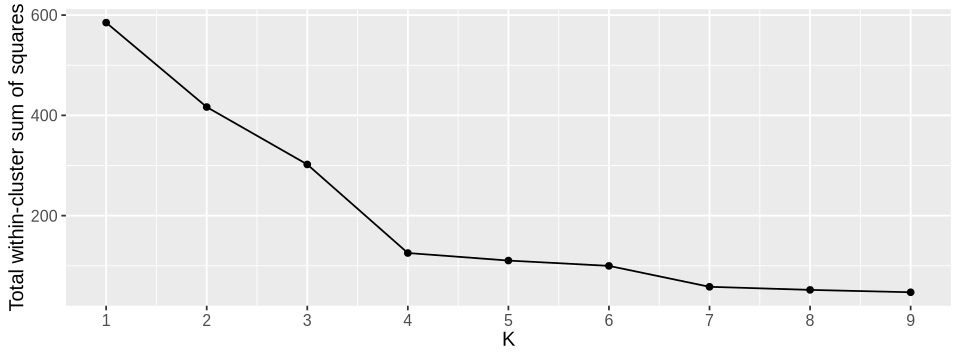

In [74]:
options(repr.plot.width = 8, repr.plot.height = 3)

kmeans_recipe <- recipe(~ experience+played_hours+age, data=players) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

kmeans_spec <- k_means(num_clusters = tune()) |>
    set_engine("stats")

players_clust_ks <- tibble(num_clusters = 1:9)

kmeans_results <- workflow() |>
    add_recipe(kmeans_recipe) |>
    add_model(kmeans_spec) |>
    tune_cluster(resamples = apparent(players), grid = players_clust_ks) |>
    collect_metrics()

kmeans_results <- kmeans_results |>
    filter(.metric == "sse_within_total") |>
    mutate(total_WSSD = mean) |>
    select(num_clusters, total_WSSD)


elbow_plot <- ggplot(kmeans_results, aes(x = num_clusters, y = total_WSSD)) +
  geom_point() +
  geom_line() +
  xlab("K") +
  ylab("Total within-cluster sum of squares") +
  scale_x_continuous(breaks = 1:9) +
  theme(text = element_text(size = 12))

elbow_plot

In [83]:
kmeans_spec_3 <- k_means(num_clusters = 3) |> set_engine("stats")
players_kmeans_fit  <- workflow() |>
    add_recipe(kmeans_recipe) |>
    add_model(kmeans_spec_3) |>
    fit(data = players)

players_clustered_data <- players_kmeans_fit |>
                    augment(players)

head(players_clustered_data)

.pred_cluster,experience,played_hours,age
<fct>,<dbl>,<dbl>,<dbl>
Cluster_1,3,30.3,9
Cluster_1,5,3.8,17
Cluster_1,5,0.0,17
Cluster_2,1,0.7,21
Cluster_1,4,0.1,21
Cluster_2,1,0.0,17


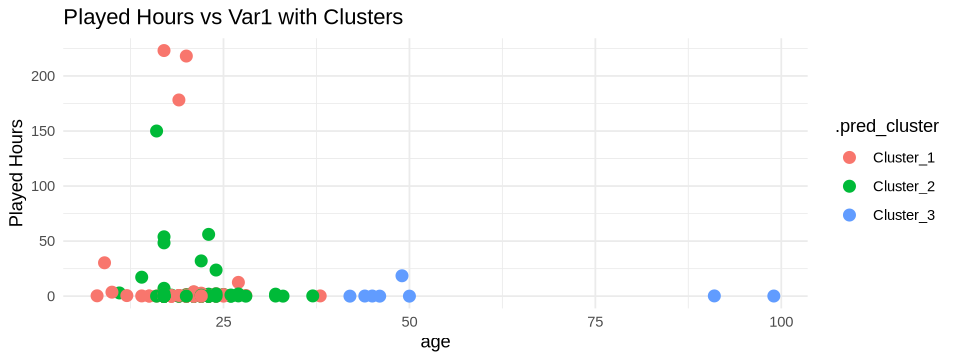

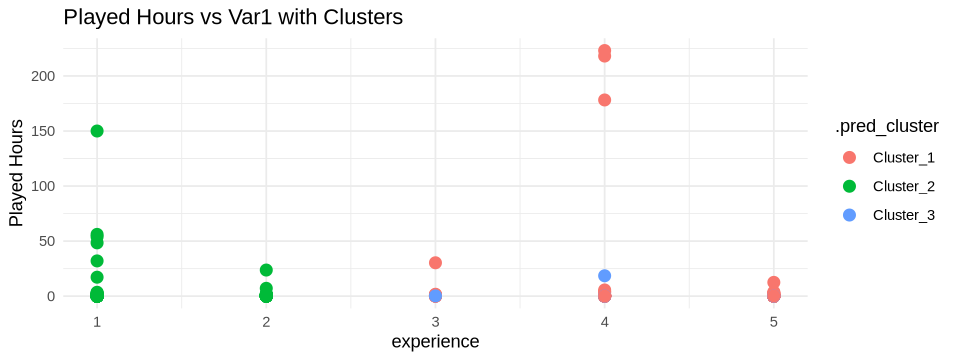

In [84]:
ggplot(players_clustered_data, aes(x = age, y = played_hours, color = .pred_cluster)) +
  geom_point(size = 3) +
  labs(title = "Played Hours vs age with Clusters",
       x = "age",
       y = "Played Hours") +
  theme_minimal()

ggplot(players_clustered_data, aes(x = experience, y = played_hours, color = .pred_cluster)) +
  geom_point(size = 3) +
  labs(title = "Played Hours vs experience with Clusters",
       x= "experience",
       y = "Played Hours") +
  theme_minimal()

## Discussion

### Our Model
The predicted `played_hours` were often far from the actual values, leading to the conclusion that our KNN regression model has little accuracy. Our data set does not contain a strong relationship between `age`, `experience` and `played_hours`. This is likely because of the distribution of ages and experience levels. From figure __, we can see that there is a much higher concentration of players on the younger end of the age spectrum than the older end which may have skewed the predictions. Furthermore, there were some outliers in the age column, with a couple of players under 10 and some players in their 90’s. This affects our model since it distorts the relationship between age and `played_hours`. There is also an imbalance of experience levels as seen in Figure __ which could have similarly skewed the predictions. Furthermore, as mentioned in the introduction, much of the data used in this analysis was collected through self reports which may not accurately represent the relationship between the variables.

This is not what we expected to find. When skimming over the data, we expected that there would be a strong relationship between the variables which could be used to determine the amount of contribution a player might make. The results from our code indicate that using age and experience as predictor variables is insufficient when looking to accurately predict play time. Since we only used these two variables, it skewed the distribution and outliers further decreased the quality of our model.

The UBC research group should consider targeting players beyond their age and experience level. Meanwhile, they should consider whether players are socially interacting in games or their in-game behavior, since that would contribute significantly to the data collected and may provide more meaningful data for player engagement.

### Answering the Question
From the visualization above, as well as our findings, there are a few conclusions that we can draw.

Primarily, it seems that in terms of the variable `age`, the players who contribute the most play time are between ages 15 and 25, contributing on average 2 hours per player. This region peaks at age 22 with an amateur player at 32 hours, although this is a significant outlier and should not be considered in the trend. However, it must be noted that this region of players has the most amount of game time due to the fact that most players, as a whole, lie in this age range.

In terms of the variable `experience`, the plot seems rather scattered and there does not seem to be a trend. However, we should note that the players with the largest `played_hours` had experience values of 1 and 4 for the majority, which correlate to amateur and regular, respectively. This may be a trend, but as of right now, there is not a strong enough correlation or enough data points to determine this.

### Further Questions
From our model:
Can we balance player experience levels and remove outliers in age to improve accuracy and address the skewed data?
Can other models such as classification models provide better conclusions?

For the UBC team:
Do game updates or events correlate with increased play times and could this provide more meaningful data?
